# Recommender System by collaborative filtering

## Team 1

- EDGAR BAZO PEREZ
- CARLOS GEOVANY PEREZ VELAZQUEZ
- ITA-ANDEHUI SANTIAGO CASTILLEJOS

This proyect objective is to implement collaborative filtering recommender system by matrix factorization algorithm. The problem consist in try to solve how Netflix is able to determine what content you’re likely to enjoy on its platform.

We will test and train the model with both dummy and Netflix movies dataset.

### Collaborative Filtering
As there are many aproaches to this problem, we will be focusing on Collaborative filtering. **Collaborative filtering does not concern itself with non-abstract features of an item, but rather uses the wisdom of the crowd to generate recommendations.** This methodology core idea is to predict how well a user will like an item that he has not rated given a set of historical preference judgments for a community of users. So we will have a user as an individual who provides movies ratings to the system and movies rated by the users.

The input for the Collaborative Filtering prediction algorithm will be a matrix of users’ ratings on movies, the **ratings matrix.**



### Matrix Factorization

Matrix factorization is a embedding model. Given the feedback matrix $D \in R^{axi}$ , where $a$ is the number of users and $i$ is the number of movies:

$$
\begin{bmatrix}
U1M1 & U1M2 \\
U2M1 & U2M2 \\
U3M1 & U3M2
\end{bmatrix}
x
\begin{bmatrix}
M1R1 & M1R2 & M1R3 \\
M2R1 & M2R2 & M2R3
\end{bmatrix}
=
\begin{bmatrix}
U1R1 & U1R2 & U1R3 \\
U2R1 & U2R2 & U2R3\\
U3R1 & U3R2 & U3R3
\end{bmatrix}
$$


- A user embedding matrix , where row i is the embedding for user i.
- An movie embedding matrix , where row j is the embedding for movie j.

The embeddings are learned such that the product $UV^T$ is a good approximation of the recommendation matrix $D$. As a result, matrix factorization finds latent structure in the data, assuming that observations lie close to a low-dimensional subspace.

## Objective Function

$$D = {(a,i) |  Y_{ai} \text{ es dada}}$$


$$J(X) = \frac{1}{2} \sum_{(a,i)\in D} (Y_{ai} - [UV^T]ai)^2 + \frac{\lambda}{2} \sum_{a=1}^n\sum_{j=1}^k U_{aj^2}$$


The core idea is to create parameters and iteratively update them to minimize some cost function, like in gradient descent: Minimizr our objective function.

- Start randomly V and U
- Fix U and solve for V
- Fix V and solve for U
- Find loss and repeat until converge(find local minimum)

In [1]:
import re
import statistics
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split


from recommender import MatrixFactorization, grid_search #our very own recommender system and grid search function

np.random.seed(seed=1983)
pd.set_option("display.max_columns", 10)

## Netflix ratings DB EDA

In [2]:
ratings = pd.read_csv("data/ratings_small.csv")

In [3]:
##Columns not needed
ratings.drop('timestamp', axis=1, inplace=True)

In [4]:
## Order by movieId
ratings.sort_values('movieId', inplace=True)

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100004 entries, 9713 to 80823
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.1 MB


In [6]:
ratings.head()

,userId,movieId,rating
9713,68,1,4.0
35933,261,1,1.5
52631,383,1,5.0
35983,262,1,2.5
12038,77,1,4.0


In [7]:
## Number of movies
len(ratings['movieId'].unique())

9066

In [8]:
## Number of users
len(ratings['userId'].unique())

671

In [9]:
## Average number of movies rated per user
ratings_per_user = ratings.groupby('userId')['rating'].count()
statistics.mean(ratings_per_user.tolist())

149.03725782414307

### Distribution of ratings per user

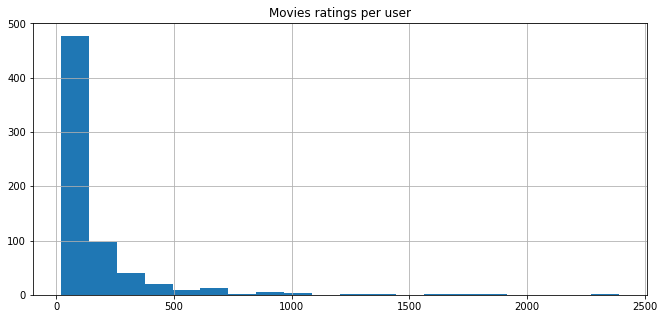

In [10]:
plt.figure(figsize = (11, 5))
ratings_per_user.hist(bins=20)
plt.title("Movies ratings per user")
plt.show()

In [11]:
## Average number of ratings given to movies
ratings_per_movie = ratings.groupby('movieId')['rating'].count()
statistics.mean(ratings_per_movie.tolist())

11.030664019413193

### Distribution of ratings per movie

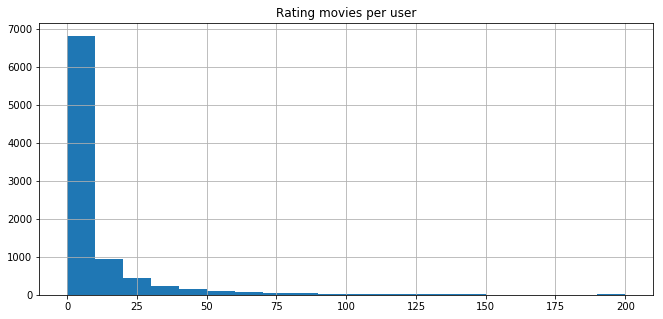

In [12]:
plt.figure(figsize = (11, 5))
ratings_per_movie.hist(bins=20, range=(0,200))
plt.title("Rating movies per user")
plt.show()

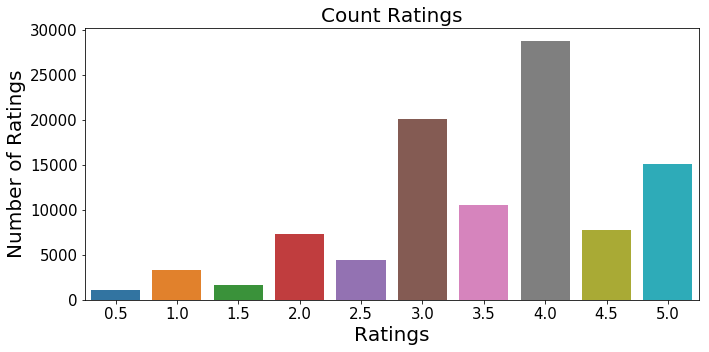

In [13]:
plt.figure(figsize = (11, 5))
sns.countplot(x="rating", data=ratings)
plt.tick_params(labelsize = 15)
plt.title("Count Ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [14]:
## Group by userid and count the numbers of movies rated by that user
ratings.groupby("userId")["rating"].count().sort_values(ascending = False).head()

userId
547    2391
564    1868
624    1735
15     1700
73     1610
Name: rating, dtype: int64

In [15]:
## Group by movies and count the number of users rated that movie
ratings.groupby("movieId")["rating"].count().sort_values(ascending = False).head()

movieId
356    341
296    324
318    311
593    304
260    291
Name: rating, dtype: int64

### Is essential to filter out movies and users with low exposure to remove some of the noise from outliers

In [16]:
min_movie_ratings = 10 #a movie has was rated at least 
min_user_ratings =  10 #a user rated movies at least

ratings = ratings.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_movie_ratings)
ratings = ratings.groupby("userId").filter(lambda x: x['userId'].count() >= min_user_ratings)

In [17]:
## pivot df to get the matrix Yai
ratings = pd.pivot_table(data=ratings,index=['userId'], columns=['movieId'], values=['rating'], aggfunc=np.sum)

In [18]:
## replace NAN with zero
ratings = ratings.fillna(0)

In [19]:
ratings.shape

(670, 2245)

In [20]:
ratings.head(5)

rating                              ...                              \
movieId 1      2      3      4      5       ... 122904 134130 134853 139385   
userId                                      ...                               
1          0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0   
2          0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0   
3          0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0   
4          0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0   
5          0.0    0.0    4.0    0.0    0.0  ...    0.0    0.0    0.0    0.0   

                
movieId 148626  
userId          
1          0.0  
2          0.0  
3          0.0  
4          0.0  
5          0.0  

[5 rows x 2245 columns]

### Netfilx movies DB EDA

In [21]:
movies_data = pd.read_csv("data/movies_metadata.csv", usecols=['genres','id','title','original_language','release_date'])

In [22]:
## Remove id and name from string
movies_data['genres'].replace({'id': ''}, inplace=True, regex=True)
movies_data['genres'].replace({'name': ''}, inplace=True, regex=True)
movies_data['genres'].replace({'\d+': ''}, inplace=True, regex=True)
## Remove special characters
movies_data['genres'].replace({'\W+': ' '}, inplace=True, regex=True)
## Remove leading and trailing blanks
movies_data['genres'] = movies_data['genres'].str.strip()
## Formatiing the string
movies_data['genres'].replace({' ': ', '}, inplace=True, regex=True)
## split in to a list
movies_data['genres'] = [x.strip('()').split(',') for x in movies_data['genres']]

In [23]:
## Cleaning id column
movies_data.drop(movies_data[movies_data['id'].str.contains("-")].index, inplace = True)
movies_data['id'] = movies_data['id'].astype('int64')
## Rename id column to movieId
movies_data.rename(columns={'id': 'movieId'}, inplace=True)

In [24]:
movies_data.head()

,genres,movieId,original_language,release_date,title
0,"[Animation, Comedy, Family]",862,en,1995-10-30,Toy Story
1,"[Adventure, Fantasy, Family]",8844,en,1995-12-15,Jumanji
2,"[Romance, Comedy]",15602,en,1995-12-22,Grumpier Old Men
3,"[Comedy, Drama, Romance]",31357,en,1995-12-22,Waiting to Exhale
4,[Comedy],11862,en,1995-02-10,Father of the Bride Part II


### Amount of movies by Language

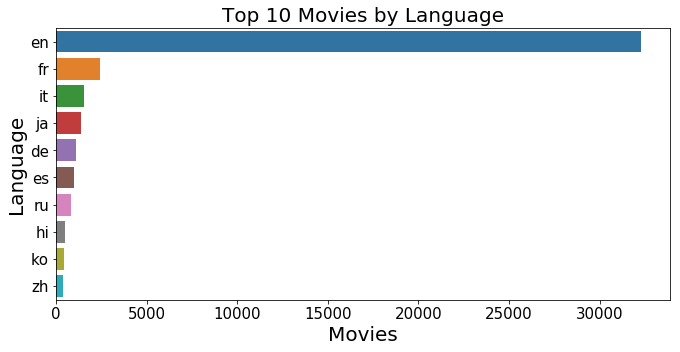

In [25]:
## Plot movies by original language
plt.figure(figsize = (11, 5))
sns.countplot(data=movies_data,
              order=movies_data.original_language.value_counts().iloc[:10].index,
              y='original_language')
plt.tick_params(labelsize = 15)
plt.title("Top 10 Movies by Language", fontsize = 20)
plt.xlabel("Movies", fontsize = 20)
plt.ylabel("Language", fontsize = 20)
plt.show()

### Amount of movies by genre

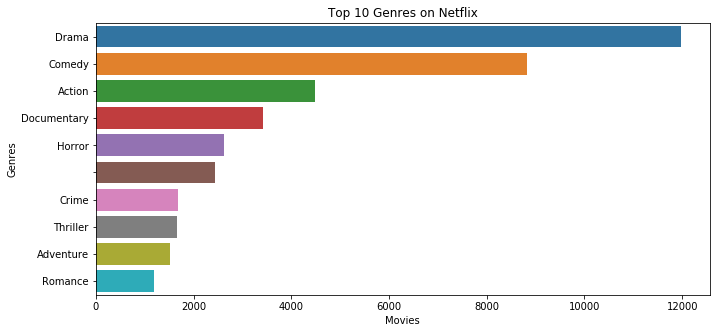

In [26]:
by_genres = movies_data.set_index('title').genres.map(lambda x: x[0]).reset_index()
plt.figure(figsize=(11,5))
sns.countplot(data=by_genres,
              order=by_genres.genres.value_counts().iloc[:10].index,
              y='genres')
plt.title('Top 10 Genres on Netflix')
plt.xlabel('Movies')
plt.ylabel('Genres')
plt.show()

## Movies Time series

In [27]:
## Counter for movies date
movies_data['count'] = 1

In [28]:
## Transform column to date type
movies_data['release_date'] =  pd.to_datetime(movies_data['release_date'], format='%Y-%m-%d')

In [29]:
movies_data['release_date'].min(), movies_data['release_date'].max()

(Timestamp('1874-12-09 00:00:00'), Timestamp('2020-12-16 00:00:00'))

In [30]:
movies_data.head(5)

,genres,movieId,original_language,release_date,title,count
0,"[Animation, Comedy, Family]",862,en,1995-10-30,Toy Story,1
1,"[Adventure, Fantasy, Family]",8844,en,1995-12-15,Jumanji,1
2,"[Romance, Comedy]",15602,en,1995-12-22,Grumpier Old Men,1
3,"[Comedy, Drama, Romance]",31357,en,1995-12-22,Waiting to Exhale,1
4,[Comedy],11862,en,1995-02-10,Father of the Bride Part II,1


In [31]:
## Group by date and count movies
daily_frame = movies_data.groupby('release_date')['count'].sum().reset_index()
daily_frame = daily_frame.set_index('release_date')
daily_frame.index = pd.to_datetime(daily_frame.index)

In [32]:
## Sum the counts of movies by year
y = daily_frame['count'].resample('MS').sum()

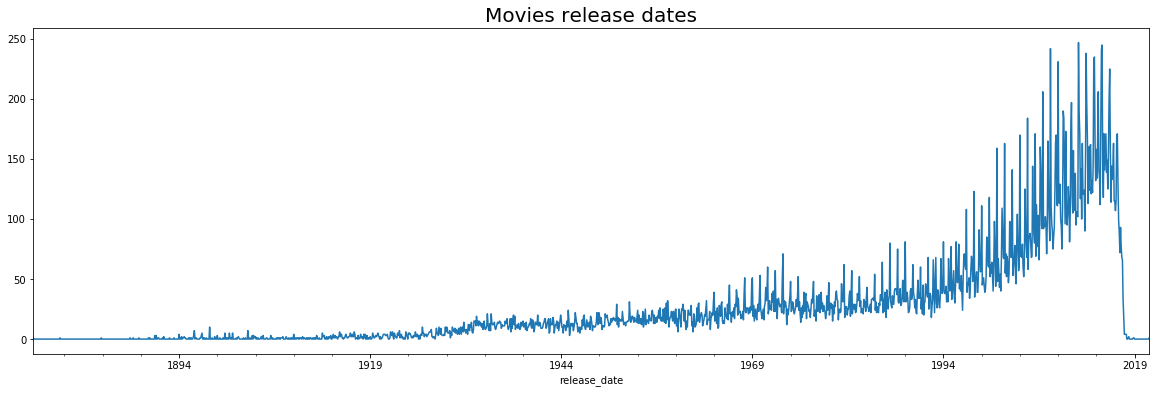

In [33]:
y.plot(figsize=(20, 6))
plt.title("Movies release dates", fontsize = 20)
plt.show()

## Train on a Dummy dataset

In [34]:
## Dummy dataset
a = pd.DataFrame([

     [1,5,3,0,1],

     [2,4,0,0,1],

     [3,1,1,0,5],

     [4,1,0,0,4],

     [5,0,1,5,4],
    
     [6,2,1,3,0],
     
     [7,4,1,2,2],
     
     [8,3,1,4,1],
    
     [9,0,1,0,3],
    
     [10,0,1,3,5],
    

    ]).set_index(0)

a.index.names = ['userId']
a.columns.names = ['movieId']

### To find the best parameters we build the method ```grid_search()``` train the models with user defined parameters as inputs.

In [35]:
params = {'Ks':[2,3],
          "alphas": [0.001,0.01,0.1],
          "epochs":[2,3,4]}

r = MatrixFactorization(a,movies_data)

clfs = grid_search(r,params)

K: 2	| alpha: 0.001	| epochs: 2	| NDCG: 0.8107262839414279
K: 2	| alpha: 0.001	| epochs: 3	| NDCG: 0.798905440053613
K: 2	| alpha: 0.001	| epochs: 4	| NDCG: 0.7154303264267667
K: 2	| alpha: 0.01	| epochs: 2	| NDCG: 0.7931434360903863
K: 2	| alpha: 0.01	| epochs: 3	| NDCG: 0.7095239280761986
K: 2	| alpha: 0.01	| epochs: 4	| NDCG: 0.8864851223037842
K: 2	| alpha: 0.1	| epochs: 2	| NDCG: 0.8788933955305674
K: 2	| alpha: 0.1	| epochs: 3	| NDCG: 0.8990584003595492
K: 2	| alpha: 0.1	| epochs: 4	| NDCG: 0.9466652288349028
K: 3	| alpha: 0.001	| epochs: 2	| NDCG: 0.7568586749814922
K: 3	| alpha: 0.001	| epochs: 3	| NDCG: 0.7443650231158847
K: 3	| alpha: 0.001	| epochs: 4	| NDCG: 0.6707790868950194
K: 3	| alpha: 0.01	| epochs: 2	| NDCG: 0.7164081733176687
K: 3	| alpha: 0.01	| epochs: 3	| NDCG: 0.7385439242145118
K: 3	| alpha: 0.01	| epochs: 4	| NDCG: 0.7694878946586268
K: 3	| alpha: 0.1	| epochs: 2	| NDCG: 0.924648443887459
K: 3	| alpha: 0.1	| epochs: 3	| NDCG: 0.8928122672932524
K: 3	| alpha: 0

In [36]:
best = clfs.loc[clfs['NDCG'].idxmin()]

In [37]:
best

K                                                         3
alpha                                                 0.001
epochs                                                    4
NDCG                                               0.670779
clf       <recommender.MatrixFactorization object at 0x0...
Name: 11, dtype: object

In [38]:
## Get the Predicted matrix
best.clf.matrix

array([[4.68989309, 1.41726879, 1.70993145, 1.07287957],
       [3.3172875 , 1.04126969, 1.44859339, 0.96654832],
       [0.59198502, 0.94191798, 2.19453875, 5.25886688],
       [0.29145172, 0.6646986 , 1.77470931, 3.87245795],
       [0.36704252, 0.60974252, 2.5758513 , 2.99525496],
       [2.47101609, 0.64036916, 1.59243687, 0.        ],
       [3.71866164, 1.29970154, 2.45204064, 1.78788797],
       [3.4469727 , 1.08674544, 2.77724232, 0.55578575],
       [0.        , 0.31715783, 0.60424488, 3.03620035],
       [0.        , 0.75336183, 2.73301905, 4.79785373]])

In [39]:
best.clf.top_recommends(1)

,movieId,userId,rating,Must watch?,title,original_language,genres,release_date
0,3,1,0,✓✓✓✓,Shadows in Paradise,fi,"[Drama, Comedy]",1986-10-16


In [41]:
## Recommended movies by top rating
users = np.random.randint(1,10,size=5)
for user in users:
    display(best.clf.top_recommends(user))

,movieId,userId,rating,Must watch?,title,original_language,genres,release_date
0,3,4,0,✓✓✓✓,Shadows in Paradise,fi,"[Drama, Comedy]",1986-10-16
1,2,4,0,✓✓✓✓,Ariel,fi,"[Drama, Crime]",1988-10-21


,movieId,userId,rating,Must watch?,title,original_language,genres,release_date
0,3,2,0,✓✓✓✓,Shadows in Paradise,fi,"[Drama, Comedy]",1986-10-16
1,2,2,0,✓✓✓✓,Ariel,fi,"[Drama, Crime]",1988-10-21


,movieId,userId,rating,Must watch?,title,original_language,genres,release_date
0,3,4,0,✓✓✓✓,Shadows in Paradise,fi,"[Drama, Comedy]",1986-10-16
1,2,4,0,✓✓✓✓,Ariel,fi,"[Drama, Crime]",1988-10-21


,movieId,userId,rating,Must watch?,title,original_language,genres,release_date
0,3,2,0,✓✓✓✓,Shadows in Paradise,fi,"[Drama, Comedy]",1986-10-16
1,2,2,0,✓✓✓✓,Ariel,fi,"[Drama, Crime]",1988-10-21


,movieId,userId,rating,Must watch?,title,original_language,genres,release_date
0,3,4,0,✓✓✓✓,Shadows in Paradise,fi,"[Drama, Comedy]",1986-10-16
1,2,4,0,✓✓✓✓,Ariel,fi,"[Drama, Crime]",1988-10-21


# Netflix movies small DB

## Finding the best K

### Discounted Cumulative Gain

The Discounted Cumulative Gain (DCG) is a relevance metric in information science and information retrieval. Unlike pure classification use cases where you are right or wrong, in a ranking problem, you are more or less right or wrong. The relevance actually denotes how well the retrieved set of documents properly answers the initial query. The most frequently used version of DCG is:

$$ DCG_p = \sum_{i=1}^p \frac{2^{rel_i} - 1}{log_2(i+1)}$$

$$ nDCG_p = \frac{DCG_P}{IDCG_p} $$

$$ \text{where} $$

$$ IDCG_p = \sum_{i=1}^{|REL_p|} \frac{2^{rel_i} - 1}{log_2(i+1)}$$

The nDCG is calculated against an ideal ranking. In case you have the ideal ranking (IDGC), your predicted ranking is compared to it. This measure helps to get the relative performance of a model given the complexity of a query.


In [ ]:
params = {'Ks':[2,3],
          "alphas": [0.001,0.01,0.1],
          "epochs":[2,3,4]}

r = MatrixFactorization(ratings,movies_data)

clfs = grid_search(r,params)

In [ ]:
best = clfs.loc[clfs['NDCG'].idxmin()]

In [ ]:
best

In [ ]:
best.clf.top_recommends(1)

## Recommendation Matrix

In [ ]:
## Get the Predicted matrix
recomm.matrix

## Geting recomendations

- Return the movies with the highest predicted rating that the specified user hasn’t already rated.

In [126]:
## Recommended movies by top rating
user = 10
recomm.top_recommends(user)

,movieId,userId,rating,Must watch?,title,original_language,genres,release_date
0,261,10,0.0,✓✓,Cat on a Hot Tin Roof,en,"[Drama, Romance]",1958-02-17
1,322,10,0.0,✓✓,Mystic River,en,"[Thriller, Crime, Drama, Mystery]",2003-10-07


In [127]:
## Recommended movies by top rating
users = np.random.randint(1,670,size=5)
for user in users:
    display(recomm.top_recommends(user))

,movieId,userId,rating,Must watch?,title,original_language,genres,release_date
0,901,656,0.0,✓✓,City Lights,en,"[Comedy, Drama, Romance]",1931-01-30
1,27721,656,0.0,✓✓,In Bar,en,[Drama],2007-01-01
2,434,656,0.0,✓✓,Tough Enough,de,"[Drama, Thriller]",2006-03-09


,movieId,userId,rating,Must watch?,title,original_language,genres,release_date
0,678,387,0.0,✓✓,Out of the Past,en,"[Drama, Mystery, Thriller]",1947-11-13
1,653,387,0.0,✓✓,Nosferatu,de,"[Fantasy, Horror]",1922-03-15
2,673,387,0.0,✓✓,Harry Potter and the Prisoner of Azkaban,en,"[Adventure, Fantasy, Family]",2004-05-31


,movieId,userId,rating,Must watch?,title,original_language,genres,release_date
0,2294,517,0.0,✓✓,Jay and Silent Bob Strike Back,en,[Comedy],2001-08-22


,movieId,userId,rating,Must watch?,title,original_language,genres,release_date
0,2252,331,0.0,✓✓,Eastern Promises,en,"[Thriller, Crime, Mystery]",2007-09-14


,movieId,userId,rating,Must watch?,title,original_language,genres,release_date
0,2072,444,0.0,✓✓✓,Cyberjack,en,"[Action, Science, Fiction, Thriller]",1995-09-19


### References

- [Sistemas de recomendación. Marmol Yahya, Juan Salvador](https://github.com/salvadormarmol/machine-learning-ms-2020/blob/master/no_supervisado/sistemas_de_recomendacion/Aprendizaje%20de%20m%C3%A1quina%20-%20Sistemas%20de%20recomendaci%C3%B3n.pdf)
- [Collaborative Filtering. Brusilovsky, Peter](https://pitt.edu/~peterb/2480-122/CollaborativeFiltering.pdf)
- [Matrix Factorization. Google developers](https://developers.google.com/machine-learning/recommendation/collaborative/matrix)
- [Python: Implementing Matrix Factorization from Scratch!. Moore, Jacob](https://towardsdatascience.com/recommender-systems-in-python-from-scratch-643c8fc4f704)
- [Collaborative Filtering: Matrix Factorization Recommender System. Stodulka Jiri](https://www.jiristodulka.com/post/recsys_cf/)
- [Discounted Cumulative Gain: the ranking metrics you should know about. Maeliza S.](https://medium.com/@maeliza.seymour/discounted-cumulative-gain-the-ranking-metrics-you-should-know-about-e1d1623f8cd9)